# Influence functions wiht EK-FAC

In [1]:
%load_ext autoreload

In [2]:
%autoreload
%matplotlib inline

import os
import random

import matplotlib.pyplot as plt
import numpy as np
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from support.common import plot_losses
from support.torch import fit_torch_model
from pydvl.influence import compute_influence_factors, compute_influences_up
from pydvl.influence.torch import TorchTwiceDifferentiable
from support.shapley import load_wine_dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from torch.optim import Adam, lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
from scipy.stats import pearsonr, spearmanr

/Users/fabio/miniconda3/envs/pydvl_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def print_error_stats(arr1, arr2, tag):
    print(
        f"Percentage error {tag}:{np.nanmean((np.abs(arr1 - arr2)/np.abs(arr2)))*100} %"
    )
    print(f"Pearson Correlation {tag}", pearsonr(arr1, arr2))
    print(f"Spearman Correlation {tag}", spearmanr(arr1, arr2))

In [4]:
from numpy import require


input_size = 13
middle_layers = [2]
output_size = 3
classification = True

train_dataset = th.utils.data.TensorDataset(
    th.randn(100, input_size), th.randint(0, output_size, (100,))
)
val_dataset = th.utils.data.TensorDataset(
    th.randn(100, input_size), th.randint(0, output_size, (100,))
)
# loss = lambda x, y: F.cross_entropy(x, y, reduction="sum")
loss = F.cross_entropy

loader = th.utils.data.DataLoader(train_dataset, batch_size=10)
val_loader = th.utils.data.DataLoader(val_dataset, batch_size=10)

layers = []
layers_size = [input_size] + middle_layers + [output_size]
new_layer = nn.Linear(input_size, input_size)
for param in new_layer.parameters():
    param.requires_grad = False
layers.append(new_layer)

for frm, to in zip(layers_size[:-1], layers_size[1:]):
    layers.append(nn.Linear(frm, to))
    layers.append(nn.Tanh())
layers.append(nn.Softmax(dim=-1))
model = nn.Sequential(*layers)

In [5]:
optimizer = Adam(model.parameters(), lr=0.1)
losses = fit_torch_model(
    model,
    training_data=train_dataset,
    val_data=val_dataset,
    loss=loss,
    optimizer=optimizer,
    num_epochs=80,
)

Model fitting:   0%|          | 0/80 [00:00<?, ?it/s]

Model fitting: 100%|██████████| 80/80 [00:05<00:00, 15.44it/s]


In [6]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of parameters: {total_params}")

Total number of parameters: 37


In [7]:
for name, p in model.named_parameters():
    if p.requires_grad:
        print(name)
        print(p.shape)

1.weight
torch.Size([2, 13])
1.bias
torch.Size([2])
3.weight
torch.Size([3, 2])
3.bias
torch.Size([3])


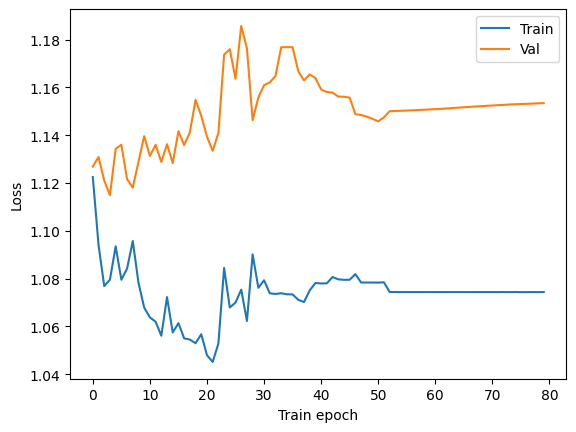

In [8]:
plot_losses(losses)

In [9]:
model.eval()
wrapped_model = TorchTwiceDifferentiable(model, loss)

In [83]:
direct_if_factors, direct_info = compute_influence_factors(
    wrapped_model,
    training_data=loader,
    test_data=loader,
    inversion_method="direct",
    hessian_perturbation=1e-1,
    progress=False,
)
direct_influences = compute_influences_up(
    wrapped_model, loader, direct_if_factors, progress=True
)
mean_direct_influences = np.mean(direct_influences.numpy(), axis=0)
direct_hessian = direct_info["hessian"]

Batch Split Input Gradients: 100%|██████████| 10/10 [00:00<00:00, 197.70it/s]


In [84]:
direct_hessian.max()

tensor(0.0003)

In [85]:
np.any(np.isnan(direct_influences.numpy()))

False

In [105]:
ekfac_if_factors, ekfac_info = compute_influence_factors(
    wrapped_model,
    training_data=loader,
    test_data=loader,
    inversion_method="ekfac",
    hessian_perturbation=1e-1,
    update_diag=True,
    full_calculation=True,
    progress=True,
)
ekfac_influences = compute_influences_up(
    wrapped_model, loader, ekfac_if_factors, progress=True
)
mean_ekfac_influences = np.mean(ekfac_influences.numpy(), axis=0)
# ekfac_hessian = ekfac_info["hessian_repr"]

Batch Test Gradients: 100%|██████████| 10/10 [00:00<00:00, 162.43it/s]


{'1.Linear(in_features=13, out_features=2, bias=True)': tensor([8.8660e-18, 1.3260e-18, 7.0488e-16, 7.1961e-17, 7.2139e-15, 8.2680e-17,
        5.6696e-16, 1.7753e-15, 1.9336e-15, 2.5211e-16, 1.0827e-14, 6.0434e-15,
        8.9170e-15, 2.6316e-14, 8.1424e-15, 3.6116e-13, 9.0636e-14, 9.4189e-13,
        5.4069e-13, 1.6404e-12, 1.0589e-12, 2.7347e-12, 9.4989e-12, 3.6652e-12,
        4.0414e-13, 3.3185e-12, 5.4728e-12, 1.1111e-11]), '3.Linear(in_features=2, out_features=3, bias=True)': tensor([6.5487e-14, 1.3421e-13, 2.0261e-15, 1.1739e-10, 2.5066e-10, 3.0166e-13,
        2.1354e-10, 1.4894e-09, 4.1539e-09])}


Batch Split Input Gradients: 100%|██████████| 10/10 [00:00<00:00, 231.67it/s]


In [106]:
ekfac_hessian = ekfac_info["hessian_repr"].get_dense_tensor()

In [107]:
ekfac_hessian.max()

tensor(2.2655e-09)

In [108]:
inverse_hessian = ekfac_info["hessian_repr"].inverse(regul=0)

In [109]:
inverse_hessian.get_dense_tensor().max()

tensor(2.1754e+17)

In [110]:
print_error_stats(mean_ekfac_influences, mean_direct_influences, tag="influence values")

Percentage error influence values:0.7599890232086182 %
Pearson Correlation influence values PearsonRResult(statistic=0.9999839143996495, pvalue=5.901345914053591e-222)
Spearman Correlation influence values SignificanceResult(statistic=0.9999909776199862, pvalue=2.9263847234982064e-234)


In [98]:
print_error_stats(mean_ekfac_influences, mean_direct_influences, tag="influence values")

Percentage error influence values:0.7599890232086182 %
Pearson Correlation influence values PearsonRResult(statistic=0.9999839143996495, pvalue=5.901345914053591e-222)
Spearman Correlation influence values SignificanceResult(statistic=0.9999909776199862, pvalue=2.9263847234982064e-234)


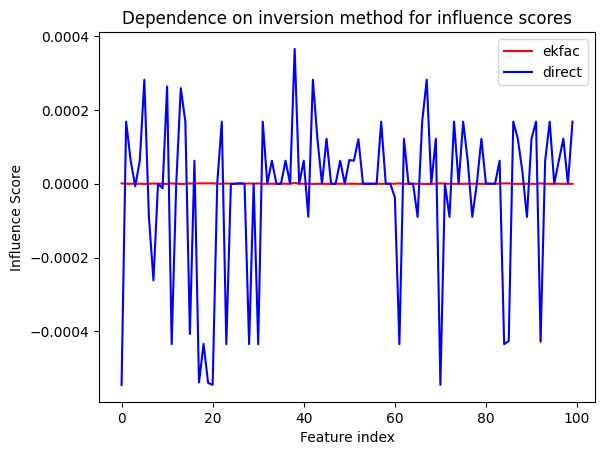

In [61]:
plt.plot(mean_ekfac_influences, color="red")
plt.plot(mean_direct_influences, color="blue")
plt.legend(["ekfac", "direct"])
plt.xlabel("Feature index")
plt.ylabel("Influence Score")
plt.title("Dependence on inversion method for influence scores")
plt.show()

In [21]:
direct_eig = np.linalg.eig(direct_hessian)[0]
# ekfac_eig = np.linalg.eig(ekfac_hessian)[0]

In [22]:
# print_error_stats(direct_eig.real, ekfac_eig.real, tag="eigen values")

In [23]:
np.sum(direct_hessian.numpy() == 0)

0

In [24]:
# ekfac_hessian - direct_hessian